In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt

import tkinter
import customtkinter

## Variáveis fixas

In [2]:
database = {
    "Usuario": ["idUsuario", "Nome", "Logradouro", "Numero", "Bairro", "CEP", "UF", "DataNascimento"],
    "Contas": ["idConta", "Descricao", "TipoConta_idTipoConta", "Usuario_idUsuario", "SaldoInicial"],
    "Movimentacao": ["idMovimentacao", "DataMovimentacao", "Descricao", "TipoMovimento_idTipoMovimento", "Categoria_idCategoria", "Contas_idConta", "Valor"],
    "TipoConta": ["idTipoConta", "Descrição"],
    "TipoMovimento": ["idTipoMovimento", "DescMovimentacao"],
    "Categoria": ["idCategoria", "DescCategoria"]
}

operators = ['=', '>', '<', '<=', '>=', '<>', 'and', 'in', 'not In', '(', ')']
operatorsBasics = ['=', '>', '<', '<=', '>=', '<>', 'in', 'not in']

commands = ['sigma', 'pi', '|x|']

In [3]:
def clean_text(text):
    return " ".join(text.split()).strip().lower()

## Exemplos

In [4]:
#text = "select Nome, DataNascimento from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario where uf = 'ce' and saldoInicial = 200"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario where uf = 'ce' and saldoInicial = 200"
#text = "select Nome, DataNascimento from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta join Movimentacao on movimentacao.contas_idconta = contas.idconta"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario where uf = 'ce' and saldoInicial = 200"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta where uf = 'ce' and saldoInicial = 200"
#text = "select * from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta join Movimentacao on movimentacao.contas_idconta = contas.idconta where uf = 'ce' and saldoInicial = 200"


#text = "select * from usuario where uf = 'ce' and saldoInicial = 200"
#text = "select Nome, DataNascimento from usuario where uf = 'ce' and saldoInicial = 200"
#text = "select idusuario, nome, datanascimento, descricao, saldoinicial, UF, Descrição from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta join Movimentacao on movimentacao.contas_idconta = contas.idconta where saldoinicial < 3000 and uf = 'ce' and Descrição <> 'Conta Corrente' and idusuario > 3;"
text = "select idusuario, nome, datanascimento, descricao, saldoinicial, UF, Descrição from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta"


## Parser

## Transformação do SQL em Álgebra Relacional

In [5]:
def transform_alg_relac(text):
    columns = [col.strip() for col in text[text.index("select")+6:text.index("from")].split(",")]

    justTheWhere = None
    if "where" in text.lower():
        justTheWhere = text[text.lower().index("where")+5:].strip()

    table = None
    if "from" in text.lower():
        table = text[text.lower().index("from")+4:].split()[0]

    tableJoin, condition = [], []
    if "join" in text.lower():
        justTheJoin = text[text.lower().index("join")+4:].strip() # pra pular o join e pegar o restante
        #tableJoin = justTheJoin[:justTheJoin.index(" on ")].strip()

        justTheJoinSplitted = justTheJoin.split('where')[0].split()

        array_index_on = [i for i in range(0, len(justTheJoinSplitted)) if justTheJoinSplitted[i].lower() == 'on']

        for x in array_index_on:
            condition.append(f'{justTheJoinSplitted[x + 1]} {justTheJoinSplitted[x + 2]} {justTheJoinSplitted[x + 3]} {justTheJoinSplitted[x - 1]}')

        # print(condition)
    if "*" not in text:
        if justTheWhere and len(condition) > 0:
            if len(condition) <= 1:
                return f"PI {' , '.join(columns)} ( Sigma {justTheWhere} ( {table} |X| {' '.join(condition)} ) )"
                #print(f"PI {' , '.join(columns)} ( Sigma {justTheWhere} ( {table} |X| {' '.join(condition)} ) )")
            else:
                for i in range(0, len(condition) - 1):
                    condition[i] += ' )'

                #print(f"PI {' , '.join(columns)} ( Sigma {justTheWhere} ( {' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)} ) )")
                return f"PI {' , '.join(columns)} ( Sigma {justTheWhere} ( {' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)} ) )"
        elif justTheWhere:
            #print(f"PI {' , '.join(columns)} ( Sigma {justTheWhere} ( {table} ) )")
            return f"PI {' , '.join(columns)} ( Sigma {justTheWhere} ( {table} ) )"
        elif len(condition) > 0:
            if len(condition) <= 1:
                # print(f"PI {' , '.join(columns)} ( {table} |X| {' '.join(condition)} )")
                return f"PI {' , '.join(columns)} ( {table} |X| {' '.join(condition)} )"
            else:
                for i in range(0, len(condition) - 1):
                    condition[i] += ' )'

                #print(f"PI {' , '.join(columns)} ( {' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)} )")
                return f"PI {' , '.join(columns)} ( {' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)} )"
        else:
            #print(f"PI {' , '.join(columns)} ( {table} )")
            return f"PI {' , '.join(columns)} ( {table} )"
    else:
        if justTheWhere and len(condition) > 0:
            if len(condition) <= 1:
                #print(f"Sigma {justTheWhere} ( {table} |X| {' '.join(condition)} )")
                return f"Sigma {justTheWhere} ( {table} |X| {' '.join(condition)} )"
            else:
                for i in range(0, len(condition) - 1):
                    condition[i] += ' )'
                #print(f"Sigma {justTheWhere} ( {' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)} )")
                return f"Sigma {justTheWhere} ( {' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)} )"
        elif justTheWhere:
            #print(f"Sigma {justTheWhere} ( {table} )")
            return f"Sigma {justTheWhere} ( {table} )"
        elif len(condition) > 0:
            if len(condition) <= 1:
                #print(f"{table} |X| {' '.join(condition)}")
                return f"{table} |X| {' '.join(condition)}"
            else:
                for i in range(0, len(condition) - 1):
                    condition[i] += ' )'
                #print(f"{' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)}")
                return f"{' ( ' * (len(condition) - 1) } {table} |X| {' |X| '.join(condition)}"
        else:
            # print(table)
            return table

## Optimização da Álgebra Relacional

In [6]:
def optimization_alg_rel(text):
    text_lower_case = text.lower()
    
    # ----------- heuristica 1 --------------
    splited_text = text_lower_case.split()
    
    array_fields = []
    index_parentense = -1
    index_sigma = -1
                
    if 'sigma' in text_lower_case:
        index_sigma = text_lower_case.index('sigma')
        
        quant_in_and_not_in = len([i for i in splited_text if i == 'in']) ## pois o in vai pegar o do not in tb
        # print(quant_in_and_not_in)
        cont_quant_in_and_not_in = 0
        
        for i in range(index_sigma + 1, len(text_lower_case)):
            
            if text_lower_case[i].find('(') != -1 and cont_quant_in_and_not_in == quant_in_and_not_in:
                index_parentense = i
                break
                
            if text_lower_case[i].find('(') != -1:
                cont_quant_in_and_not_in += 1
                
    if index_sigma != -1:
        aux_text_lower_case = text_lower_case[index_sigma:index_parentense].replace('sigma', '')
        substring_sigma_text = re.split("and", aux_text_lower_case)
        substring_sigma_text = [sentence.strip() for sentence in substring_sigma_text]
                
        # print(substring_sigma_text)
        for substring in substring_sigma_text:
            array_fields.append(substring)
    
    dict_tables_aux = { 
        "Usuario": [],
        "Contas": [],
        "Movimentacao": [],
        "TipoConta": [],
        "TipoMovimento": [],
        "Categoria": []
    }
    
    dict_sigma_in_table = {
        "Usuario": False,
        "Contas": False,
        "Movimentacao": False,
        "TipoConta": False,
        "TipoMovimento": False,
        "Categoria": False
    }
    
    for sentence in array_fields:
        for table in database.keys():
            # achou = dict_field.get('field').lower() in [x.lower() for x in database.get(table)]
            
            value = sentence.split()[0].lower()
            
            value_split_dot = value.split('.') 
            
            if len(value_split_dot) >= 2:
                value = value_split_dot[1]
            
            achou = value in [x.lower() for x in database.get(table)]
            
            if achou:
                dict_tables_aux.get(table).append(sentence)   
    # print(dict_tables_aux)
    
    text_lower_case = text_lower_case.replace("sigma", '')
    text_lower_case = text_lower_case.replace('and', '')
    
    for table in dict_tables_aux.keys():
        cont = 0
        array_aux = dict_tables_aux.get(table)
                
        if len(array_aux) > 0:
            # verificação se nessa tabela tem sigma pros valores
            dict_sigma_in_table[table] = True
            
            textTransformed = 'sigma'
            
            for value_aux in array_aux:      
                
                # textBase = dict_aux.get('field') + " " + dict_aux.get('operator') + " " + dict_aux.get('value')
                textBase = value_aux

                text_lower_case = text_lower_case.replace(textBase, '')
                
                #if cont > 0:
                 #   textTransformed = textTransformed + " ( " + textBase 
                #else:
                    
                cont += 1
                
                if cont >= 2:
                    textTransformed = textTransformed + " and " + textBase 
                else:
                    textTransformed = textTransformed + " " + textBase 
                
                if cont >= len(array_aux):
                    # textTransformed += " ( " + table + " ) " + " ".join([")" for i in range(cont)])
                    textTransformed += " ( " + table + " ) "
                    
            text_lower_case = re.sub(r"(\(|\b)" + table.lower() + r"(\)|\b)(?!\.\w)", textTransformed, text_lower_case)
            # text_lower_case = text_lower_case.replace(textBase, textTransformed)

    text_lower_case = " ".join(text_lower_case.split())
    
    # ----------- heuristica 2 --------------
    
    array_fields_must_need = []
    text_lower_case = text_lower_case.lower()

    splited_text = text_lower_case.split()
    
    for i in range(0, len(splited_text) - 1):
        if splited_text[i] == 'pi':
            for j in range(i + 1, len(splited_text)): # ajeitar dps
                if splited_text[j] == '(':
                    break
                array_fields_must_need.append(splited_text[j])
            break
                
    for i in range(0, len(splited_text)):
        if splited_text[i] == '|x|':
            chave1 = splited_text[i + 1].split('.')
            chave2 = splited_text[i + 3].split('.')
            
            aux_chave1 = splited_text[i + 1]
            aux_chave2 = splited_text[i + 3]
            
            if len(chave1) > 1:
                aux_chave1 = chave1[1]
            
            if len(chave2) > 1:
                aux_chave2 = chave2[1]
            
            if not(aux_chave1 in array_fields_must_need):
                array_fields_must_need.append(aux_chave1)
                
            if not(aux_chave2 in array_fields_must_need):
                array_fields_must_need.append(aux_chave2)
            #break
    
    dict_tables_aux_fields_must_need = { 
        "Usuario": [],
        "Contas": [],
        "Movimentacao": [],
        "TipoConta": [],
        "TipoMovimento": [],
        "Categoria": []
    }        
    
    for field in array_fields_must_need:
        for table in database.keys():
            value = field.split()[0].lower()
            
            value_split_dot = value.split('.') 
            
            if len(value_split_dot) >= 2:
                value = value_split_dot[1]
                
            achou = value in [x.lower() for x in database.get(table)]
           # print(field.lower())
           # print(achou)
           # print()
            if achou:
                dict_tables_aux_fields_must_need.get(table).append(field)  
    # print(dict_sigma_in_table)
    # print(dict_tables_aux_fields_must_need)
    for table in dict_tables_aux_fields_must_need.keys():
        cont = 0
        array_aux = dict_tables_aux_fields_must_need.get(table)
        
        if len(array_aux) > 0:
            
            if len(array_aux) >= 2:
                textTransformed = ' ( pi ' + " , ".join(array_aux) + " ( "
            else:
                textTransformed = ' ( pi ' + " ".join(array_aux) + " ( "
            
            if table.lower() in splited_text:
                #index_sigma = splited_text.index('sigma') # trocar isso, pois praticamente tem q ter sigma para funcionar
                index_table = splited_text.index(table.lower())
                # print(index_table)
                
                if dict_sigma_in_table.get(table) == True:
                    for k in range(index_table, 0, -1):
                        if splited_text[k] == 'sigma':
                            index_sigma = k
                            break
                    textBase = " ".join([splited_text[i] for i in range(index_sigma, index_table + 1)])
                else:
                    textBase = " " + splited_text[index_table] + " "
                
                text_lower_case = text_lower_case.lower()
                
                textTransformed += textBase + " ) ) "

                text_lower_case = text_lower_case.replace(textBase, textTransformed)
                text_lower_case = " ".join(text_lower_case.split())
            #print(text_lower_case)
            
            
                
    #print(dict_tables_aux_fields_must_need)
    
    return text_lower_case

## Construção do Grafo

In [7]:
class Vertice:
    
    def __init__(self, text, n_order):
        self.text = text
        self.n_order = n_order

    def add_adjacente(self, adjacente):
        self.adjacentes.append(adjacente)
        
    def __str__(self):
        return f'{self.text} | ordem: {self.n_order}'

In [8]:
def remover_parenteses_aninhados(texto):
    pilha = []
    novo_texto = ""
    for caractere in texto:
        if caractere == "(":
            pilha.append(caractere)
        elif caractere == ")":
            if pilha:
                pilha.pop()
            else:
                novo_texto += caractere
        elif not pilha:
            novo_texto += caractere
    return novo_texto

In [9]:
def remover_parenteses_aninhados_special_sigma(texto):
    pilha = []
    novo_texto = ""
    passed_in = False
    
    for i, caractere in enumerate(texto):
        
        if texto[i] == 'i' and i < len(texto): ## ver se antes tem o in para nao ignorar os parenteses
            if texto[i:i+2] == 'in':
                passed_in = True
            
        if caractere == "(" and passed_in == False:
            pilha.append(caractere)
        elif caractere == ")":
            if pilha:
                pilha.pop()
            else:
                novo_texto += caractere
                
            passed_in = False
        elif not pilha:
            novo_texto += caractere
            
    return novo_texto

In [10]:
def call_remover_parenteses_aninhados(texto):
    splitted_text = texto.split()
    if splitted_text[0] == 'sigma':
        return remover_parenteses_aninhados_special_sigma(texto)
    else:
        return remover_parenteses_aninhados(texto)
    

In [11]:
def create_grafo(alg_rel_optimized):
    G = nx.MultiGraph() # grafo
    
    splitted_text = alg_rel_optimized.split()
    
    array_parenteses = []
    nivel_parentese = 0
    
    stack = []
    
    for index in range(0, len(splitted_text)):
        if splitted_text[index] == '(':
            nivel_parentese += 1
            dict_aux_abrir = { "indexAbrir": index, "nivelParentese": nivel_parentese }
            
            stack.append(dict_aux_abrir)
            #array_parenteses.append(dict_aux)
        if splitted_text[index] == ')':
            dict_join_abrir_fechar = stack.pop()
            dict_aux_fechar = { "indexFechar": index, "nivelParentese": nivel_parentese }
            dict_join_abrir_fechar.update(dict_aux_fechar)
            
            array_parenteses.append(dict_join_abrir_fechar)
            
            nivel_parentese -= 1
    
    
    array_parenteses_clean = []
    text_aux_anterior = None
    
    ## tudo que estiver entre parentenses é removido
    for i in array_parenteses:
        text_aux = " ".join(splitted_text[i['indexAbrir']+1:i['indexFechar']])
        #print(text_aux)
        
        if text_aux_anterior != None:
            
            text_aux = call_remover_parenteses_aninhados(text_aux).strip()
        #print(text_aux)
            
        array_parenteses_clean.append(text_aux)
        
        text_aux_anterior = " ".join(splitted_text[i['indexAbrir']+1:i['indexFechar']])
    
    text_aux = " ".join(splitted_text) # pegar string toda devido ao pi que pode ter no começo
    text_aux = remover_parenteses_aninhados(text_aux).strip()
    array_parenteses_clean.append(text_aux)
    
    array_parenteses_clean = [x for x in array_parenteses_clean if len(x) > 0]
    #for i in array_parenteses_clean:
     #   print(i)
    
    cont_order = 0
    array_nodes_order_exec = []
    
    for text in array_parenteses_clean:
        text_aux = text
        #print(text_aux)
        node = Vertice(text_aux, cont_order)
        
        array_nodes_order_exec.append(node)
        G.add_node(node)
        cont_order += 1   
    
    node_anterior = None
    array_node_join = []
    
    print(array_parenteses_clean)
    
    for node_atual in array_nodes_order_exec:
        
        if len(array_node_join) >= 1 and '|x|' in node_atual.text:
                G.add_edge(array_node_join[0], node_atual)
                G.add_edge(node_anterior, node_atual)
                
                array_node_join = []
    
        is_only_table = node_atual.text.lower() in [x.lower() for x in database.keys()]
        if is_only_table and node_anterior != None:        
            array_node_join.append(node_anterior)
            
            node_anterior = None

        if node_anterior != None:
            G.add_edge(node_anterior, node_atual)

        node_anterior = node_atual
        
    
    return G

In [12]:
def draw_grafo(grafo_ord_exec):
    plt.figure(figsize=(30,25))

    pos = nx.spring_layout(grafo_ord_exec)
    nx.draw_networkx(grafo_ord_exec, pos, with_labels=True)
    plt.savefig('grafo-sql')
    plt.show()

In [13]:
def steps_execution(sql_sentence):
    ## parser = parser(sql_sentence)
    
    text_alg_relacional = clean_text(transform_alg_relac(sql_sentence))
    
    alg_relac_optimized = clean_text(optimization_alg_rel(text_alg_relacional))
    
    grafo_ord_exec = create_grafo(alg_relac_optimized)
    
    draw_grafo(grafo_ord_exec)
    

## Front da Aplicação

['usuario', "sigma uf ='ce' and cep <> '62930000' and nome in ('alex', 'joelma')", 'pi nome , datanascimento , idusuario', 'contas', 'sigma saldoinicial >= 235 and saldoinicial not in (250, 270)', 'pi descricao , saldoinicial , usuario_idusuario', '|x| usuario.idusuario = contas.usuario_idusuario', 'pi nome , datanascimento , descricao , saldoinicial']


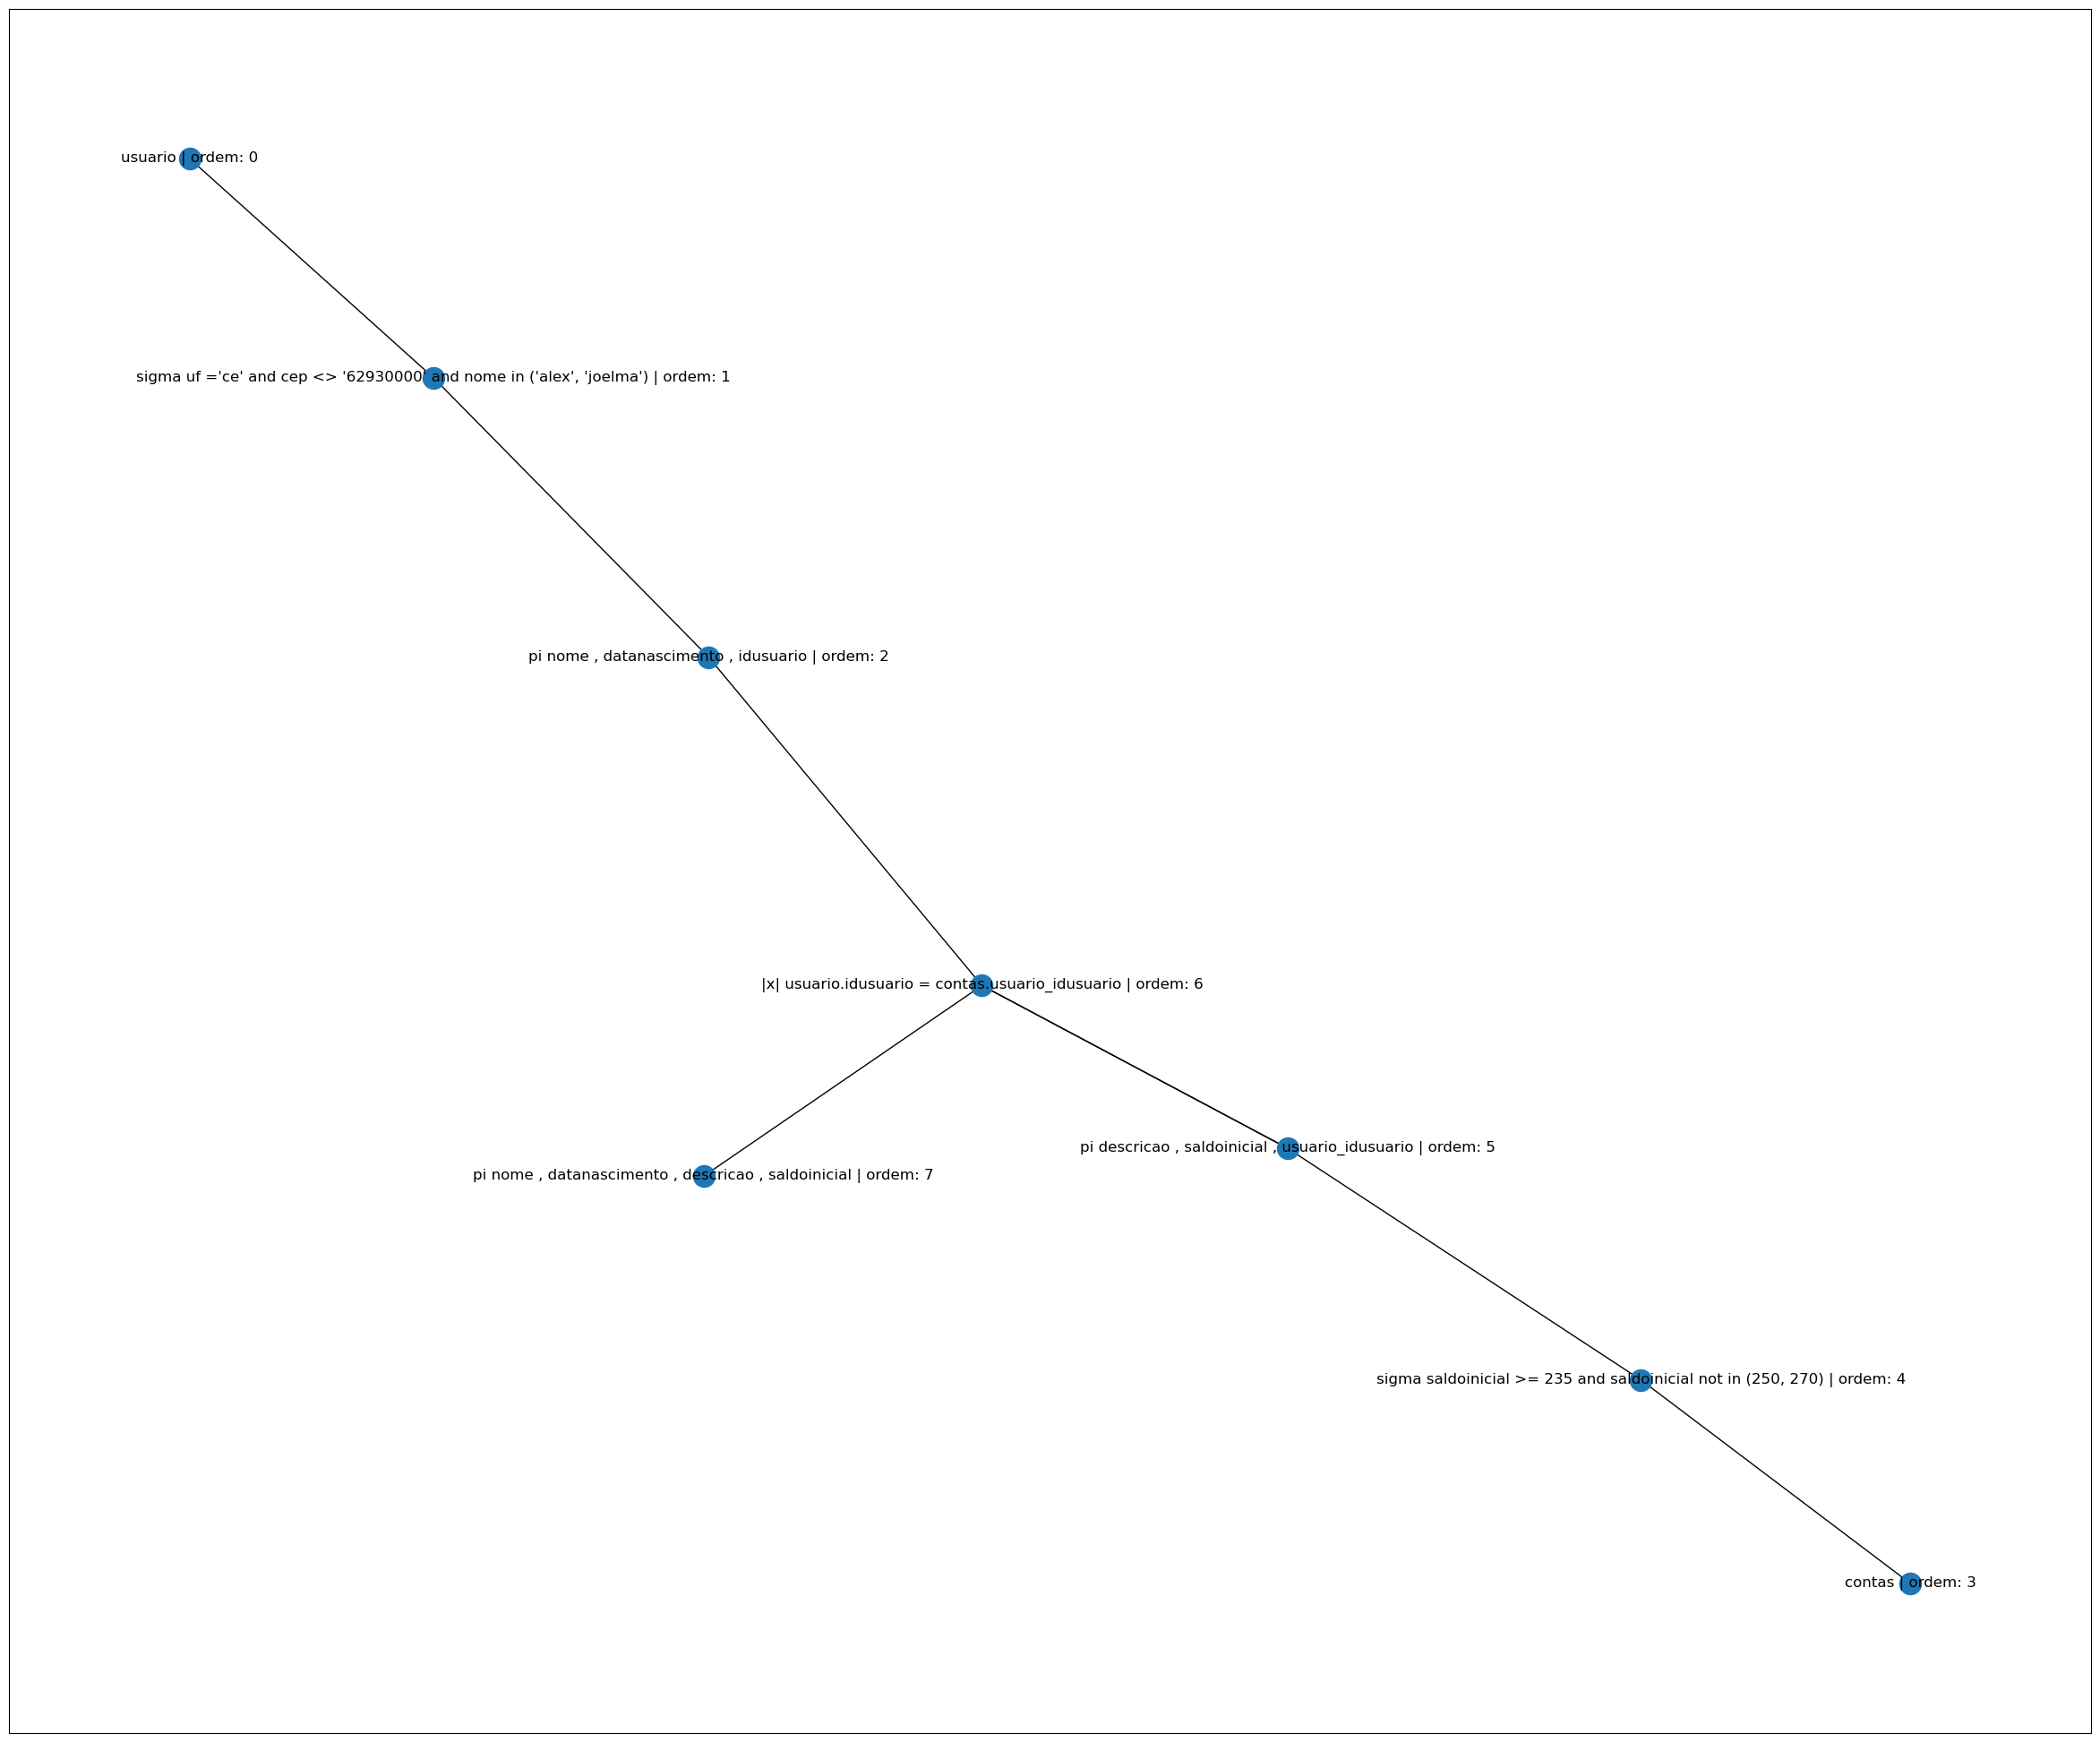

In [14]:
customtkinter.set_appearance_mode("dark")
customtkinter.set_default_color_theme("dark-blue")

root = customtkinter.CTk()
root.geometry("900x640")
root.title("Projeto de Banco de Dados")
    
frame = customtkinter.CTkFrame(master=root)
frame.pack(pady=20, padx=50, fill="both", expand=True)

# inicializar algumas variáveis para não dar erro
sql_sentence = customtkinter.StringVar(value="")


def buttonVerifySQL():
    steps_execution(sql_sentence.get())
    
    

labelTitle = customtkinter.CTkLabel(master=frame, text="Projeto de Banco de Dados", font=customtkinter.CTkFont(size=20, weight="bold")).grid(row=1,column=2)

labelWhite = customtkinter.CTkLabel(master=frame, text=" ").grid(row=2,column=1)
labelWhite = customtkinter.CTkLabel(master=frame, text=" ").grid(row=3,column=1)
labelWhite = customtkinter.CTkLabel(master=frame, text=" ").grid(row=4,column=1)

labelTitle = customtkinter.CTkLabel(master=frame, text="SQL", font=customtkinter.CTkFont(size=16)).grid(row=5,column=1)
entryWordsPerPage = customtkinter.CTkEntry(master=frame, textvariable=sql_sentence, width=700).grid(row=5,column=2)
labelWhite = customtkinter.CTkLabel(master=frame, text=" ").grid(row=6,column=2)
buttonWordsPerPage = customtkinter.CTkButton(master=frame, text="Confirmar", command=buttonVerifySQL).grid(row=8,column=2)



root.mainloop()
    